In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.impute import SimpleImputer

In [21]:
# Load dataset
df = pd.read_csv('test-data/2015_to_2022_dataset.csv')

In [22]:
# Replace missing values with NaN
df.replace("", np.nan, inplace=True)

In [23]:
df.isnull().sum()

Code                         0
Locale                       0
Date                         0
Temperature                  7
Precipitation            63134
Wind_Speed                  55
Wind_Direction              68
Humidity                    35
Vapor_Pressure               7
Dew_Point_Temperature       10
Spot_Atm_Pressure           21
Sea_Level_Pressure          17
Daylight_Time            32027
Insolation               31852
Snowfall_Amount          68051
Clouds_Amount             7111
Ground_Temperature          67
SO2                       1486
CO                        2672
NO2                       2074
PM10                      1436
PM2_5                     1330
O3                        1397
dtype: int64

In [24]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.strftime('%y%m%d%H')
df['Date'] = df['Date'].astype(int)

df['Year'] = df['Date'].apply(lambda x: 2000 + int(str(x)[:2]))  # Adding 2000 to get the full year, e.g., 2015
df['Month'] = df['Date'].apply(lambda x: int(str(x)[2:4]))
df['Day'] = df['Date'].apply(lambda x: int(str(x)[4:6]))
df['Hour'] = df['Date'].apply(lambda x: int(str(x)[6:]))

In [25]:
# Define the columns to be imputed with the median
median_columns = [
    'Temperature', 'Wind_Speed', 'Wind_Direction', 'Humidity',
    'Vapor_Pressure', 'Dew_Point_Temperature', 'Spot_Atm_Pressure',
    'Sea_Level_Pressure', 'SO2', 'CO', 'NO2', 'PM10', 'PM2_5', 'O3',
    'Ground_Temperature'
]

# Define the columns to be imputed with zero
zeroing_columns = [
    'Precipitation', 'Daylight_Time', 'Insolation',
    'Snowfall_Amount', 'Clouds_Amount'
]

# Create imputer for median
imputer_median = SimpleImputer(strategy='median')

# Apply the imputer to the columns that require the median
df[median_columns] = imputer_median.fit_transform(df[median_columns])

# Fill the NaN values with zero for the columns that require zeroing
df[zeroing_columns] = df[zeroing_columns].fillna(0)

# Check if there are any remaining NaN values
print(df.isnull().sum())

Code                     0
Locale                   0
Date                     0
Temperature              0
Precipitation            0
Wind_Speed               0
Wind_Direction           0
Humidity                 0
Vapor_Pressure           0
Dew_Point_Temperature    0
Spot_Atm_Pressure        0
Sea_Level_Pressure       0
Daylight_Time            0
Insolation               0
Snowfall_Amount          0
Clouds_Amount            0
Ground_Temperature       0
SO2                      0
CO                       0
NO2                      0
PM10                     0
PM2_5                    0
O3                       0
Year                     0
Month                    0
Day                      0
Hour                     0
dtype: int64


In [26]:
df = df.drop(columns = ['Code','Date', 'Locale'])

In [67]:
df = df.drop(columns = ['NO2','SO2', 'CO','PM10','PM2_5'])

<AxesSubplot:>

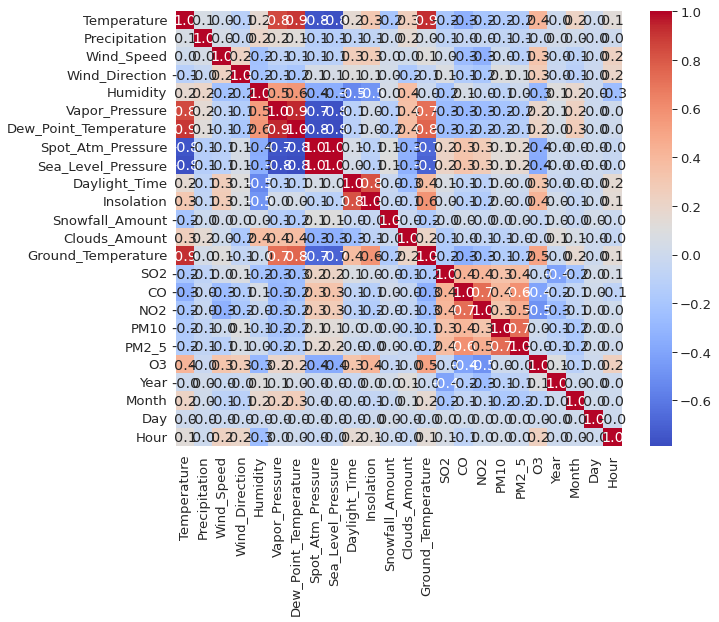

In [27]:
corr = df.corr()

sns.set_style('whitegrid')

sns.set_context('paper', font_scale=1.5)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f')

In [28]:
# Specify the target variable
y = df['O3']

In [29]:
# Specify the feature variables
X = df.drop(['O3'], axis=1)

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# Build the enhanced DNN model
def build_enhanced_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Dense(32),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Dense(1)
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [33]:
input_shape = (X_train.shape[1],)
model = build_enhanced_model(input_shape)
model.summary()

# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(
    X_train, y_train,
    epochs=200,  # Increased number of epochs
    batch_size=32,  # Adjusted batch size
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stop]
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               6144      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)              

In [34]:
# Evaluate the model
predictions = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE: {:.4f}".format(rmse))
print("MAE: {:.4f}".format(mae))
print("R^2: {:.4f}".format(r2))

RMSE: 0.0086
MAE: 0.0067
R^2: 0.8013


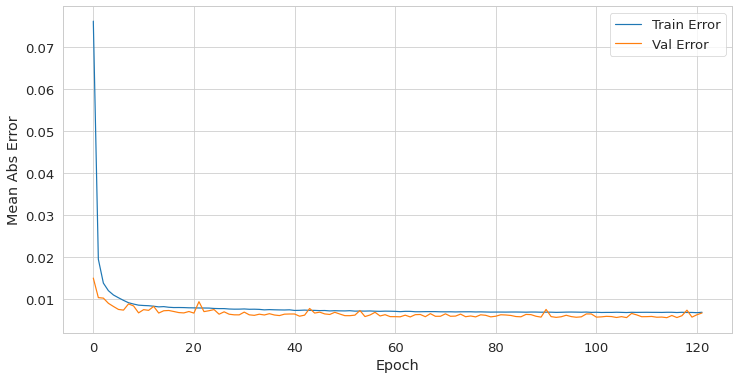

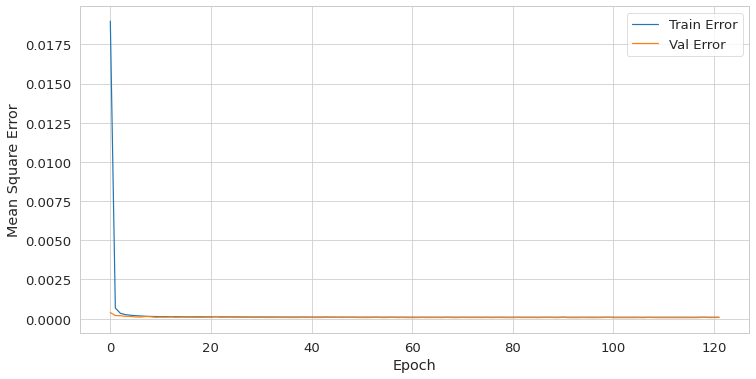

In [35]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,6))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.legend()
    plt.show()
    
plot_history(history)

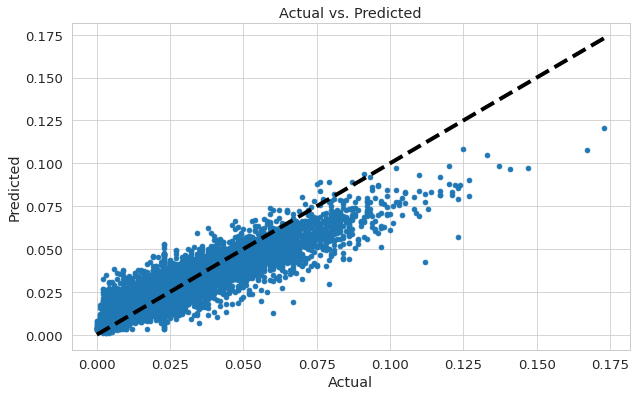

In [19]:
# Plot Actual vs. Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

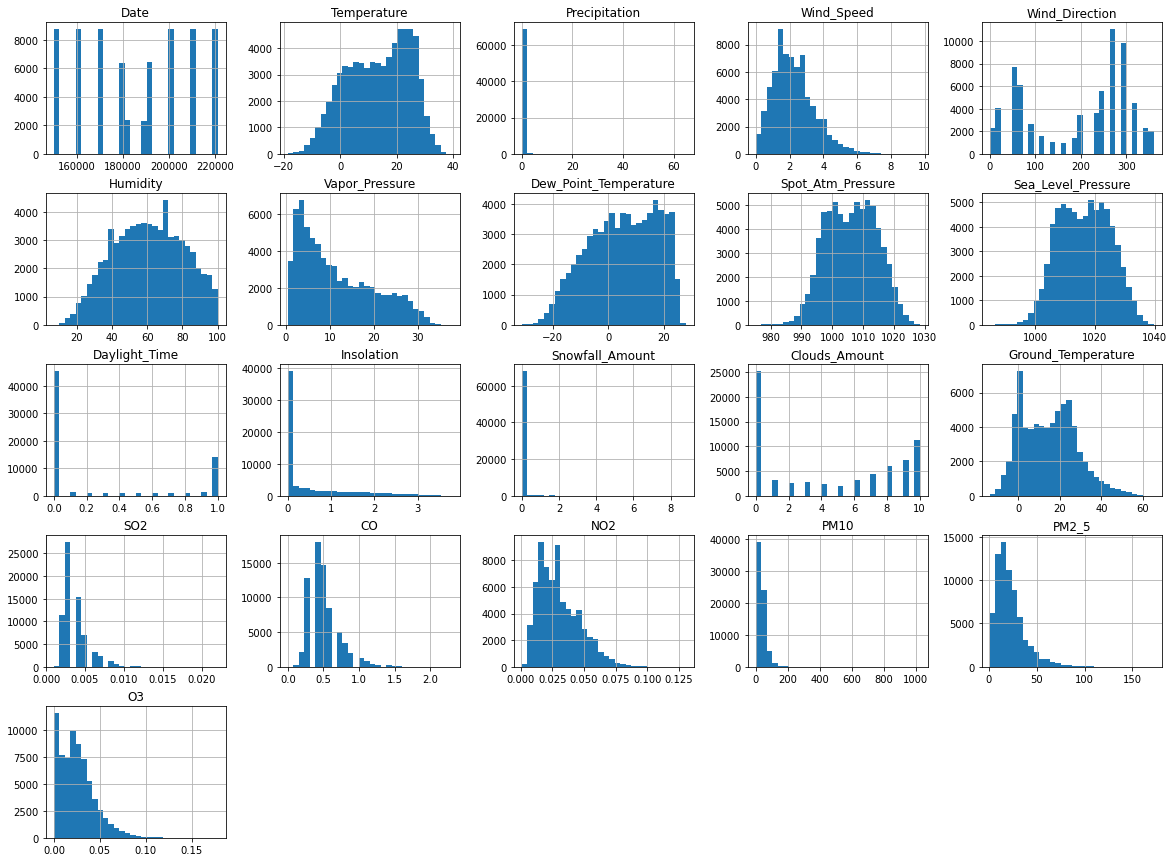

In [60]:
# Histograms for each variable in your dataset
df.hist(bins=30, figsize=(20,15))
plt.show()

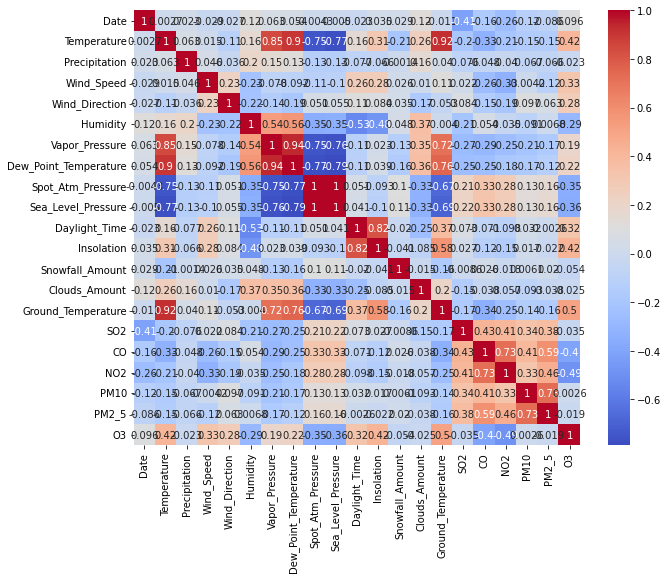

In [62]:
# Heatmap of Correlations
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

ValueError: num must be 1 <= num <= 15, not 16

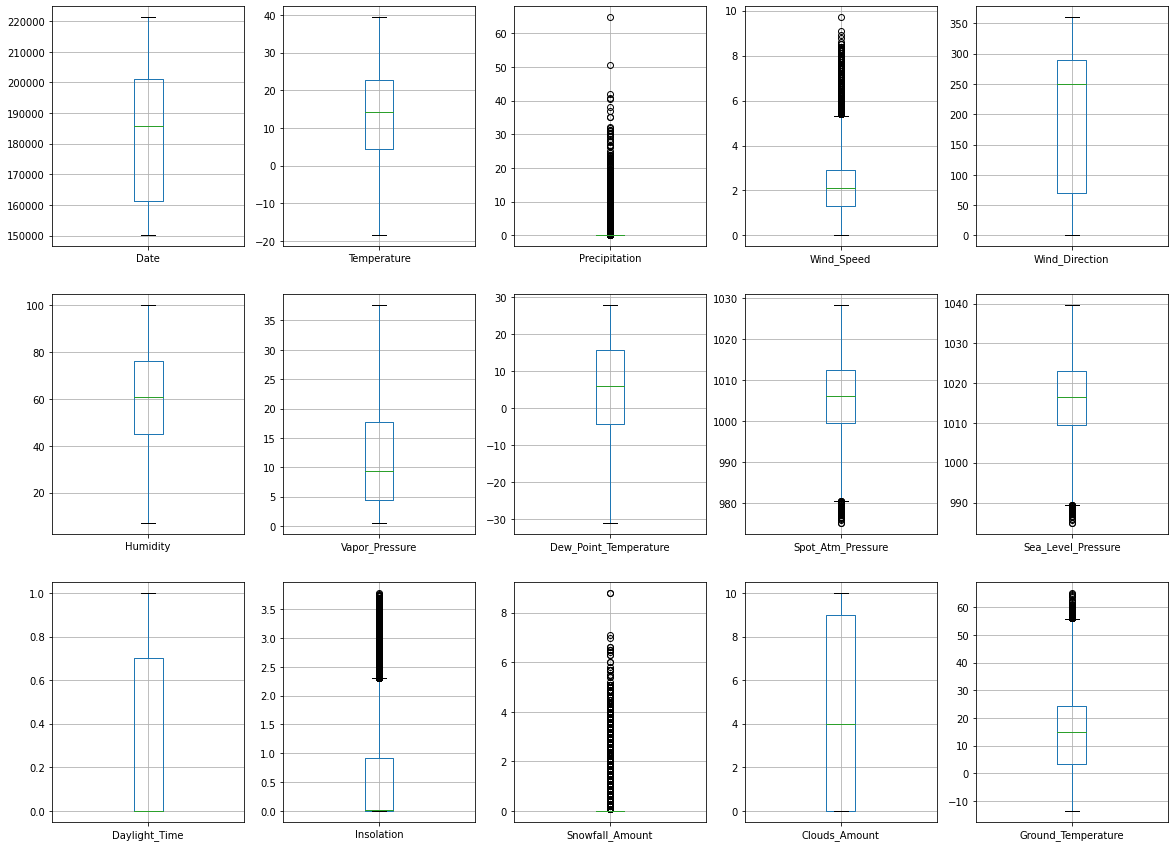

In [61]:
# Box plots for each variable
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 5, i)
    df.boxplot(column)
plt.show()